In [1]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
from tqdm import tqdm
import random
from random import shuffle
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from training_utils import CNN2D, spectra_stats, SpectraDataset

Seed set to 42


In [2]:
# Set a fixed seed value
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
pl.seed_everything(SEED)
print("Seed has been set")

Seed set to 42


Seed has been set


# Training CNN on Spectrograms

## Data Loading

In [3]:
# Path to dataset
base_path = "..\preprocessed_dset"
data_path = os.path.join(base_path, "spectrograms")
meta_path = os.path.join(base_path, "metadata.csv")

In [4]:
# Data stats for normalization
    
mean, std = spectra_stats(data_path, meta_path)

(..\preprocessed_dset\spectrograms) Mean: [0.68137387 0.66712049 0.64939852], Std: [0.13272135 0.1345285  0.13304515] (calculated and saved)


In [10]:
# Define Dataset and DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])



train_dset = SpectraDataset(data_path=data_path,
                            dataframe_path=meta_path,
                            transform = transform,
                            split="train")
test_dset = SpectraDataset(data_path=data_path,
                            dataframe_path=meta_path,
                            transform = transform,
                            split="test",
                            get_metadata=True,
                            same_amount=False)

train_dset_c = SpectraDataset(data_path=data_path,
                            dataframe_path=meta_path,
                            transform = transform,
                            split="train",
                            colocated=True)
test_dset_c = SpectraDataset(data_path=data_path,
                            dataframe_path=meta_path,
                            transform = transform,
                            split="test",
                            get_metadata=True,
                            colocated=True,
                            same_amount=False)

# print dset dimensions
print(f"Dataset -> Train: {len(train_dset)}, Test: {len(test_dset)}")
print(f"Dataset (Excluding colocated events) -> Train: {len(train_dset_c)}, Test: {len(test_dset_c)}")



# Define Dataloader

train_data = DataLoader(train_dset, batch_size=32, shuffle=True)
test_data = DataLoader(test_dset, batch_size=32, shuffle=False)
sample_batch, _ = next(iter(train_data))  # Assuming labels exist, ignore them with "_"

# Get the spatial shape (height, width) of the images
sample_shape = sample_batch.shape[-2:]

print("\nTraining batch shape: ", sample_batch.shape) 

train_data_c = DataLoader(train_dset_c, batch_size=32, shuffle=True)
test_data_c = DataLoader(test_dset_c, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")


Dataset -> Train: 3534, Test: 1165
Dataset (Excluding colocated events) -> Train: 3434, Test: 1265

Training batch shape:  torch.Size([32, 3, 33, 96])
using device: cuda


In [7]:
def split_train_cross_val(dataset, n_splits=7):
    splits = []
    size = (len(dataset) // n_splits)
    last_size = len(dataset) - size*(n_splits-1)
    out = random_split(dataset, [size]*(n_splits - 1) + [last_size])
    for idx in range(n_splits):
        train = torch.utils.data.ConcatDataset([out[i] for i in range(n_splits) if i != idx])
        val = out[idx]
        splits.append((train, val))
        print(f"Split {idx}: Train: {len(train)}, Val: {len(val)}")
    print()
    return splits


splits = split_train_cross_val(train_dset)
splits_c = split_train_cross_val(train_dset_c)

Split 0: Train: 3030, Val: 504
Split 1: Train: 3030, Val: 504
Split 2: Train: 3030, Val: 504
Split 3: Train: 3030, Val: 504
Split 4: Train: 3030, Val: 504
Split 5: Train: 3030, Val: 504
Split 6: Train: 3024, Val: 510

Split 0: Train: 2944, Val: 490
Split 1: Train: 2944, Val: 490
Split 2: Train: 2944, Val: 490
Split 3: Train: 2944, Val: 490
Split 4: Train: 2944, Val: 490
Split 5: Train: 2944, Val: 490
Split 6: Train: 2940, Val: 494



## Training

In [11]:
best_model_accuracy = 0
best_model_path = None

for idx, (train_dset, val_dset) in enumerate(splits):
    model = CNN2D(input_dim=sample_shape)
    
    print(f"Training model for fold {idx}...")
    early_stop_callback = EarlyStopping(monitor='val_acc', patience=3, mode='max')
    checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, dirpath='model_checkpoints', filename=f'best_model_fold_{idx}')
    
    trainer = pl.Trainer(
        max_epochs=10, 
        accelerator='gpu',
        devices=-1, 
        callbacks=[early_stop_callback, checkpoint_callback],
        enable_model_summary = (False if idx > 0 else True)
    )
    
    trainer.fit(model, DataLoader(train_dset, batch_size=32, shuffle=True), DataLoader(val_dset, batch_size=32, shuffle=False))
    
    val_acc = trainer.callback_metrics.get('val_acc', 0).item()  # Extract validation accuracy
    
    if val_acc > best_model_accuracy:
        best_split = idx
        best_model_accuracy = val_acc
        best_model_path = checkpoint_callback.best_model_path
        print(f"New best model found for fold {idx} with valid accuracy: {val_acc:.4f}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type             | Params | Mode 
---------------------------------------------------------
0  | conv1      | Conv2d           | 896    | train
1  | BatchNorm1 | BatchNorm2d      | 64     | train
2  | conv2      | Conv2d           | 18.5 K | train
3  | BatchNorm2 | BatchNorm2d      | 128    | train
4  | conv3      | Conv2d           | 73.9 K | train
5  | BatchNorm3 | BatchNorm2d      | 256    | train
6  | maxpool    | MaxPool2d        | 0      | train
7  | relu       | ReLU             | 0      | train
8  | dropout    | Dropout          | 0      | train
9  | flatten    | Flatten          | 0      | train
10 | fc1        | Linear           | 3.1 M  | train
11 | fc2        | Linear           | 258    | train
12 | criterion  | CrossEntropyLoss | 0      | train
-------------------------------------------------------

Training model for fold 0...
Epoch 4: 100%|██████████| 95/95 [00:13<00:00,  6.82it/s, v_num=2, train_loss=0.0511, val_loss=0.0181, val_acc=0.996]   
New best model found for fold 0 with valid accuracy: 0.9960
Training model for fold 1...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 6: 100%|██████████| 95/95 [00:11<00:00,  8.19it/s, v_num=3, train_loss=2.55e-5, val_loss=0.0229, val_acc=0.996] 
Training model for fold 2...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 8: 100%|██████████| 95/95 [00:13<00:00,  6.80it/s, v_num=4, train_loss=3.01e-5, val_loss=0.00598, val_acc=0.998] 
New best model found for fold 2 with valid accuracy: 0.9980
Training model for fold 3...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5: 100%|██████████| 95/95 [00:14<00:00,  6.70it/s, v_num=5, train_loss=1.59e-5, val_loss=0.0106, val_acc=0.994]  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training model for fold 4...
Epoch 5: 100%|██████████| 95/95 [00:14<00:00,  6.41it/s, v_num=6, train_loss=0.000234, val_loss=0.00736, val_acc=0.996]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training model for fold 5...
Epoch 7: 100%|██████████| 95/95 [00:16<00:00,  5.92it/s, v_num=7, train_loss=9.44e-6, val_loss=0.00623, val_acc=0.998] 
Training model for fold 6...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4: 100%|██████████| 95/95 [00:15<00:00,  6.26it/s, v_num=8, train_loss=0.000202, val_loss=0.0044, val_acc=0.996] 


In [12]:
train_dset, val_dset = splits_c[best_split]
model = CNN2D(input_dim=sample_shape)

early_stop_callback = EarlyStopping(monitor='val_acc', patience=3, mode='max')
checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, dirpath='model_checkpoints', filename=f'best_model_c_fold_{best_split}')

trainer = pl.Trainer(
    max_epochs=10, 
    accelerator='gpu',
    devices=-1, 
    callbacks=[early_stop_callback, checkpoint_callback],
    enable_model_summary = True
)

trainer.fit(model, DataLoader(train_dset, batch_size=32, shuffle=True), DataLoader(val_dset, batch_size=32, shuffle=False))

best_model_c_path = checkpoint_callback.best_model_path

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\miche\OneDrive\Desktop\EQML Project\CNN-Explainability-on-Earthquakes\CNN_EQML\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\miche\OneDrive\Desktop\EQML Project\CNN-Explainability-on-Earthquakes\training\model_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type             | Params | Mode 
---------------------------------------------------------
0  | conv1      | Conv2d           | 896    | train
1  | BatchNorm1 | BatchNorm2d      | 64     | train
2  | conv2      | Conv2d           | 18.5 K | train
3  | BatchNorm2 | BatchNorm2d      | 128    | train
4  | conv3      | Conv2d           | 73.9 K | train
5  | BatchNorm3 | BatchNorm2d      | 256    | train
6  | maxpool    | MaxPool2d        | 0      | train
7  | relu       | ReLU             | 0      | train
8  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\miche\OneDrive\Desktop\EQML Project\CNN-Explainability-on-Earthquakes\CNN_EQML\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\miche\OneDrive\Desktop\EQML Project\CNN-Explainability-on-Earthquakes\CNN_EQML\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 92/92 [00:14<00:00,  6.49it/s, v_num=9, train_loss=6.22e-5, val_loss=0.0306, val_acc=0.996] 


In [13]:
print(f"Best model: {best_model_path}")
print(f"Best model (with excluded): {best_model_c_path}")

Best model: C:\Users\miche\OneDrive\Desktop\EQML Project\CNN-Explainability-on-Earthquakes\training\model_checkpoints\best_model_fold_2.ckpt
Best model (with excluded): C:\Users\miche\OneDrive\Desktop\EQML Project\CNN-Explainability-on-Earthquakes\training\model_checkpoints\best_model_c_fold_2.ckpt


## Metrics on Test Set

In [ ]:
best_model_path = r"..\training\model_checkpoints\best_model_fold_2.ckpt"
best_model_c_path = r"..\training\model_checkpoints\best_model_c_fold_2.ckpt"

In [7]:
def compute_test_metrics(model_path, test_dset, input_dim):
    model = CNN2D.load_from_checkpoint(model_path, input_dim=input_dim, n_classes=2)
    trainer = pl.Trainer(enable_model_summary=False, logger=False, enable_progress_bar=False)
    trainer.test(model, test_dset)

Testing Metrics for Spectrogram dataset:


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\EQML Project\CNN-Explainability-on-Earthquakes\CNN_EQML\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


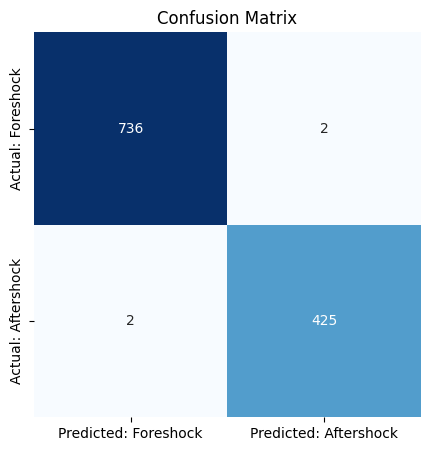

Total Accuracy: 0.9966
Total Precision: 0.9953
Total Recall: 0.9953
Total F1 Score: 0.9953
Testing Metrics for Spectrogram dataset (without colocated events):


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\EQML Project\CNN-Explainability-on-Earthquakes\CNN_EQML\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


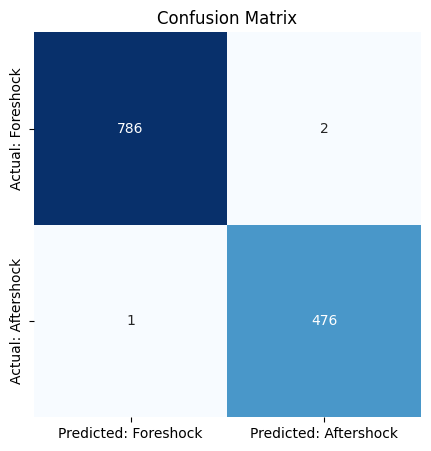

Total Accuracy: 0.9976
Total Precision: 0.9958
Total Recall: 0.9979
Total F1 Score: 0.9969


In [8]:
print("Testing Metrics for Spectrogram dataset:")
compute_test_metrics(best_model_path, test_data, sample_shape)

print("Testing Metrics for Spectrogram dataset (without colocated events):")
compute_test_metrics(best_model_c_path, test_data_c, sample_shape)

## Preparing Test Dataset for Explainability

In [12]:
pick = 300 # Number of correct predicted random samples to pick for each class
correct_aftershock_samples = []
correct_foreshock_samples = []

model = CNN2D.load_from_checkpoint(best_model_path, input_dim=sample_shape, n_classes=2)
model.eval()
model.to(device)

for img, label, trace_name, *_ in tqdm(test_data, desc="Checking correct samples"):
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    _, predicted = torch.max(output, 1)
    correct = (predicted == label).squeeze()
    for i in range(len(correct)):
        if correct[i]:
            if label[i] == 1:
                correct_aftershock_samples.append(trace_name[i])
            else:
                correct_foreshock_samples.append(trace_name[i])

    if len(correct_aftershock_samples) >= pick and len(correct_foreshock_samples) >= pick:
        break

shuffle(correct_aftershock_samples)
shuffle(correct_foreshock_samples)
correct_aftershock_samples = correct_aftershock_samples[:pick]
correct_foreshock_samples = correct_foreshock_samples[:pick]

print(f"Correct aftershock samples: {len(correct_aftershock_samples)}")
print(f"Correct foreshock samples: {len(correct_foreshock_samples)}")


output_explain_path = r"..\explainability\samples\aftershocks"
os.makedirs(output_explain_path, exist_ok=True)
for name in tqdm(correct_aftershock_samples, desc="Copying aftershock samples"):
    img_path = os.path.join(data_path, name + ".png")
    
    # Copy and Paste the image to the output folder
    os.system(f"copy {img_path} {output_explain_path}")

output_explain_path = r"..\explainability\samples\foreshocks"
os.makedirs(output_explain_path, exist_ok=True)
for name in tqdm(correct_foreshock_samples, desc="Copying foreshock samples"):
    img_path = os.path.join(data_path, name + ".png")
    
    # Copy and Paste the image to the output folder
    os.system(f"copy {img_path} {output_explain_path}")

Checking correct samples:  59%|█████▉    | 22/37 [00:03<00:02,  5.74it/s]


Correct aftershock samples: 300
Correct foreshock samples: 300


Copying foreshock samples: 100%|██████████| 300/300 [00:17<00:00, 17.52it/s]
